## ASSIGNMENT_03

NAME:- SHORAJ TOMER 


ROLL NUM:- MDS201931

Import required libraries

In [1]:
import warnings                
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import math
import random
import itertools

from scipy import stats
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats import kurtosis
from scipy.stats import skew
from statsmodels.compat import lzip

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARIMA

from arch import arch_model
from scipy.stats import shapiro
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight') 
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
%matplotlib inline

np.random.seed(123)

Data Set: DownLoad the data Set

https://finance.yahoo.com/quote/MU/history?p=MU

For this assignment, i used MU stoke Price Data set. There are total of 253 instance containing Open Price, High price, low price, Close, Adj Close and Volume Price. Here is the link of used data set


https://github.com/shoraj1551/TSA-Assignment3-Finance-Data/blob/main/MU.csv

Define Important Functions

In [2]:
# Function Check_data check what percentage of data lies in the range mean +_ 3*sigma
def check_data(x):
    sigma = x.std()
    mean = x.mean()
    c = 0 
    for i in range(len(x)):
        if x[i] > (mean -3*sigma) and x[i] < (mean + 3*sigma):
            c = c + 1
    per_data = (c/len(x))*100

    print(f'Percentage of data between mean-3*sigma and mean+3*sigma is : {per_data}')
    

#define function for ADF test
def Adf_test(series):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p_value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print(f'Result: The series is {"not " if dftest[1] > 0.05 else ""}stationary')
          

#Define function for KPSS test
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
          
          
# Define function for PP test
def pp_test(series):    
    pp = PhillipsPerron(series)
    print(pp.summary().as_text())

Import the MU data set and apply some basic analysis 

In [3]:
data = pd.read_csv("MU.csv", sep=",", index_col = 'Date')
data.shape

(253, 6)

In [4]:
# Description of Data Set
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-28,48.500000,48.750000,48.230000,48.689999,48.689999,15240000
2019-10-29,48.799999,49.169998,48.060001,48.110001,48.110001,12183600
2019-10-30,48.220001,48.340000,47.259998,47.880001,47.880001,12932800
2019-10-31,47.279999,47.880001,46.459999,47.549999,47.549999,15445800
2019-11-01,47.480000,48.540001,47.250000,48.380001,48.380001,18311700


In [5]:
# For Analysis we have used closed price of data set

df = data['Close']
print(df)

Date
2019-10-28    48.689999
2019-10-29    48.110001
2019-10-30    47.880001
2019-10-31    47.549999
2019-11-01    48.380001
2019-11-04    49.590000
2019-11-05    48.680000
2019-11-06    47.680000
2019-11-07    48.400002
2019-11-08    47.189999
2019-11-11    46.259998
2019-11-12    46.900002
2019-11-13    46.299999
2019-11-14    46.799999
2019-11-15    47.709999
2019-11-18    47.820000
2019-11-19    46.580002
2019-11-20    45.570000
2019-11-21    45.549999
2019-11-22    45.869999
2019-11-25    47.520000
2019-11-26    46.720001
2019-11-27    48.160000
2019-11-29    47.509998
2019-12-02    46.389999
2019-12-03    45.230000
2019-12-04    46.299999
2019-12-05    46.619999
2019-12-06    47.930000
2019-12-09    46.450001
                ...    
2020-09-16    50.209999
2020-09-17    50.980000
2020-09-18    50.740002
2020-09-21    49.150002
2020-09-22    49.700001
2020-09-23    49.849998
2020-09-24    49.470001
2020-09-25    49.139999
2020-09-28    49.720001
2020-09-29    50.709999
2020-09-30 

In [6]:
# WE will check if there is some missing value
df = data['Close']
miss = []
for j in range(len(df)):
    if math.isnan(df[j])== True:
        miss.append(j)
print(miss)

[]


it means there is no missing value in our data set.

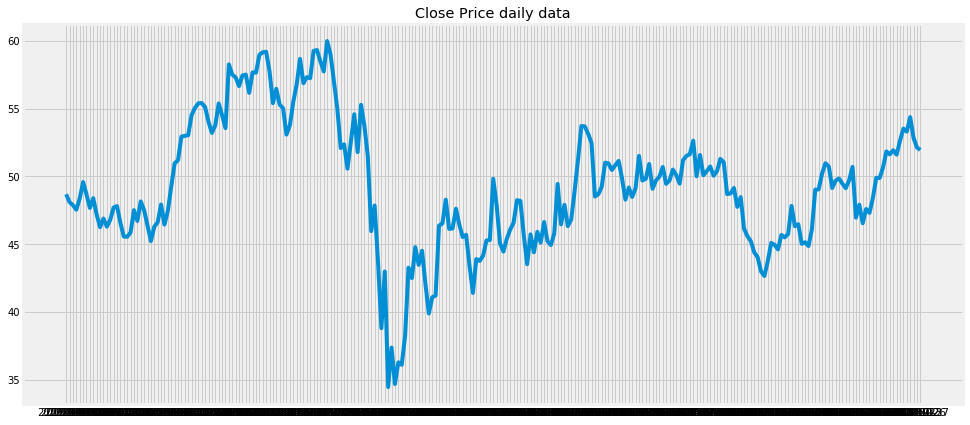

In [7]:
# PLOT the given time series data
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.title('Close Price daily data')
plt.grid(True)
plt.show()

Lets distribute the Data as Test data and Train Data Set. In train data set we have 246 observations and for test data set we have 7 observations.

In [8]:
train_data = df[:-7]
test_data = df[-7:]

#print(train_data)
print(test_data)

Date
2020-10-19    52.630001
2020-10-20    53.529999
2020-10-21    53.310001
2020-10-22    54.380001
2020-10-23    52.849998
2020-10-26    52.139999
2020-10-27    51.959999
Name: Close, dtype: float64


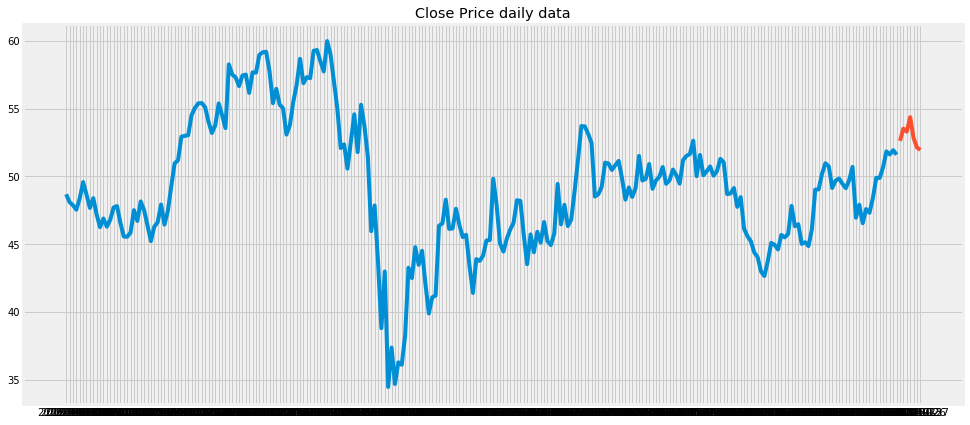

In [9]:
# PLOT the Train and Test Data in a single plot
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.title('Close Price daily data')
plt.grid(True)
plt.show()

Descriptive Analysis on Train Data set

In [10]:
train_data.describe()

count    246.000000
mean      49.178902
std        4.792936
min       34.470001
25%       46.100000
50%       48.834999
75%       51.645002
max       59.990002
Name: Close, dtype: float64

In [11]:
k = train_data.kurtosis()
s = train_data.skew()
print(f'Kurtosis: {k}')
print(f'skew: {s}')

Kurtosis: 0.35120584871353566
skew: -0.013829126571873802


In [12]:
check_data(train_data)

Percentage of data between mean-3*sigma and mean+3*sigma is : 99.1869918699187


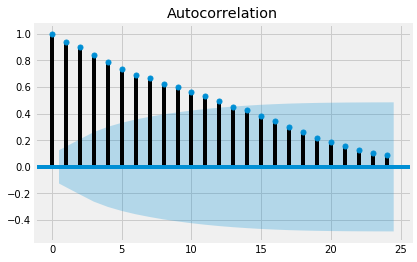

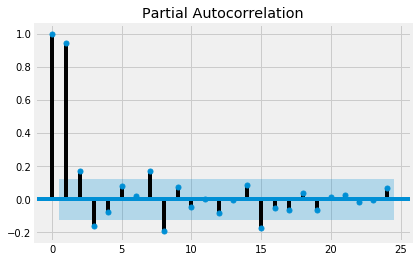

In [13]:
plot_acf(train_data)
plt.show()

plot_pacf(train_data)
plt.show()

Now we Apply the Stationarity test for this training Data set

In [14]:
Adf_test(train_data)

Results of Dickey-Fuller Test:
Test Statistic                  -2.428109
p_value                          0.133959
#Lags Used                       7.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64
Result: The series is not stationary


In [15]:
warnings.filterwarnings('ignore')
kpss_test(train_data)

KPSS Statistic: 0.19188535182865635
p-value: 0.1
num lags: 16
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


In [16]:
pp_test(train_data)

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.813
P-value                         0.056
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Now we need to convert our data as a stationary time series. Since our data is financial data so lets take log return data.

In [17]:
data['log_ret'] = np.log(df) - np.log(df.shift(1))
r_t = data['log_ret']
#print(r_t)

In [18]:
# Here we drop all NaN value
r_t = r_t.dropna()
#print(r_t)

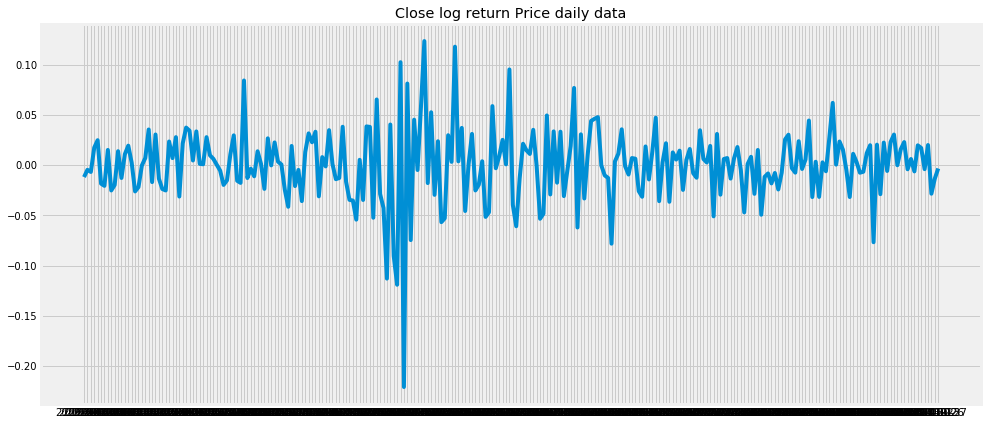

In [19]:
# PLOT the time series data
plt.figure(figsize=(15, 7))
plt.plot(r_t)
plt.title('Close log return Price daily data')
plt.grid(True)
plt.show()

In [20]:
# Break the data as test and train Data

logtrain_data = r_t[:-7]
logtest_data = r_t[-7:]
#print(logtrain_data)
print(logtest_data)

Date
2020-10-19    0.019571
2020-10-20    0.016956
2020-10-21   -0.004118
2020-10-22    0.019873
2020-10-23   -0.028539
2020-10-26   -0.013525
2020-10-27   -0.003458
Name: log_ret, dtype: float64


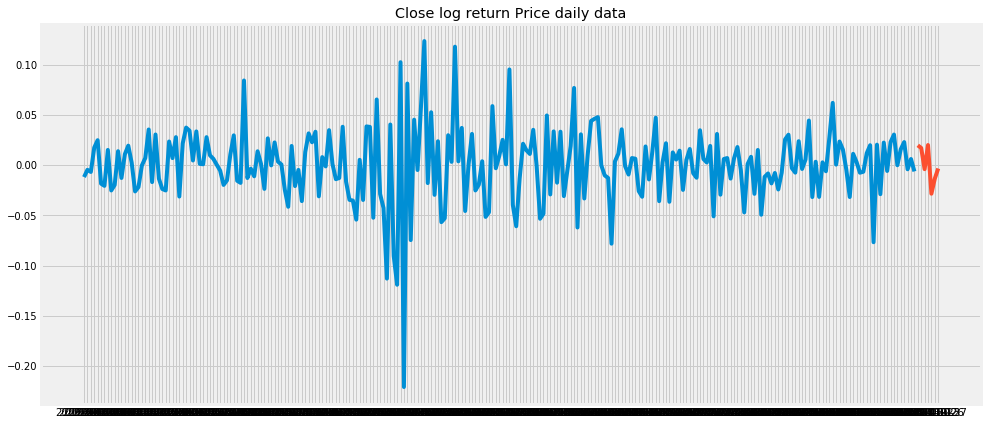

In [21]:
# PLot the logtrain and logtest data in a single ts graph

plt.figure(figsize=(15, 7))
plt.plot(logtrain_data.index, logtrain_data)
plt.plot(logtest_data.index, logtest_data)
plt.title('Close log return Price daily data')
plt.grid(True)
plt.show()

Descriptive statistics of logtrain_data

In [22]:
logtrain_data.describe()

count    245.000000
mean       0.000238
std        0.036703
min       -0.220878
25%       -0.018300
50%        0.001133
75%        0.021511
max        0.123316
Name: log_ret, dtype: float64

In [23]:
k = logtrain_data.kurtosis()
s = logtrain_data.skew()
print(f'Kurtosis: {k}')
print(f'skew: {s}')

Kurtosis: 6.110329174624285
skew: -0.7814073710042004


In [24]:
check_data(logtrain_data)

Percentage of data between mean-3*sigma and mean+3*sigma is : 97.95918367346938


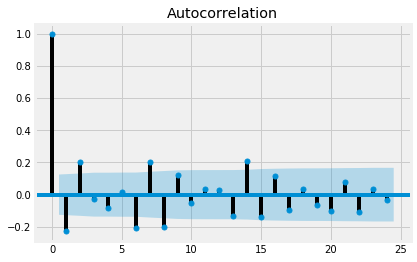

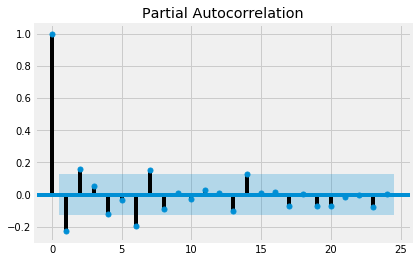

In [25]:
plot_acf(logtrain_data)
plt.show()

plot_pacf(logtrain_data)
plt.show()

Now we Apply the Stationarity test for this training Data set

In [26]:
Adf_test(logtrain_data)

Results of Dickey-Fuller Test:
Test Statistic                -6.050032e+00
p_value                        1.284157e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64
Result: The series is stationary


In [27]:
kpss_test(logtrain_data)

KPSS Statistic: 0.053543548110701576
p-value: 0.1
num lags: 16
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


In [28]:
pp_test(logtrain_data)

     Phillips-Perron Test (Z-tau)    
Test Statistic                -19.665
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Now We fit the ARIMA MODEL

We need to find out optimal value for the parameter p and q in ARIMA model. We select the Value of p and q corresponding to minimum value of AIC and BIC

In [29]:
# for paprameter selection 
# Input m and n are the maximum possible value of parameter p and q respectively.
def par_sel (m,n):
    AB = {}
    for p in range(m):
        for q in range(n):
            try:
                mod = ARIMA(logtrain_data, order= (p,0,q))
                result = mod.fit()
                AB[(p,q)] = [result.aic, result.bic]
            except:
                continue
    return AB

In [30]:
par_sel(5,5)

{(0, 0): [-921.1169356893963, -914.1144192683068],
 (0, 1): [-928.726956379396, -918.2231817477618],
 (0, 2): [-938.587584835553, -924.5825519933741],
 (0, 3): [-936.6698360572342, -919.1635450045105],
 (0, 4): [-936.0678051434196, -915.0602558801512],
 (1, 0): [-932.2045110574176, -921.7007364257834],
 (1, 1): [-933.4350969616875, -919.4300641195085],
 (1, 2): [-936.6416295070218, -919.1353384542981],
 (1, 3): [-941.026349475345, -920.0188002120766],
 (1, 4): [-936.3367545640298, -911.8279470902166],
 (2, 0): [-936.4382232937231, -922.4331904515442],
 (2, 1): [-934.6976431998588, -917.1913521471351],
 (2, 2): [-946.7267419717988, -925.7191927085304],
 (3, 0): [-935.1051538849948, -917.5988628322712],
 (3, 1): [-940.1286317653504, -919.121082502082],
 (3, 2): [-935.9387779646744, -911.4299704908613],
 (4, 0): [-936.5098168788583, -915.5022676155899],
 (4, 1): [-936.4393953753985, -911.9305879015853],
 (4, 2): [-942.6208236225469, -914.6107579381891],
 (4, 3): [-937.9076804627917, -906.

From Above we find best value of parameters for the data set is p = 3 and q =2 

In [31]:
# FIT appropriate ARIMA model
p = 3
q = 2
mod = ARIMA(logtrain_data, order =(p,0,q))
result = mod.fit()
print(result.aic)

# Compare AIC and BIC value for p = 3 and q = 2
print(result.aic, result.bic)

-935.9387779646744
-935.9387779646744 -911.4299704908613


Forecast on logtest_data

In [32]:
history = [x for x in logtrain_data]
predictions = list()
for t in range(len(logtest_data)):
    model= ARIMA(history, order=(3,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = logtest_data[t]
    history.append(obs)

    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_data, predictions)
print('Test MSE: %.3f' % error)

predicted=0.001378, expected=0.019571
predicted=-0.005422, expected=0.016956
predicted=-0.000060, expected=-0.004118
predicted=0.005759, expected=0.019873
predicted=-0.004108, expected=-0.028539
predicted=0.007151, expected=-0.013525
predicted=-0.003763, expected=-0.003458
Test MSE: 2806.565


Final Prediction and MSE in terms of Close Price

In [33]:
fin_pred = [train_data[-1]]
for i in range(len(test_data)):
    x = fin_pred[-1]
    y = predictions[i]
    fin_pred.append(x*math.exp(y))
fin_pred = fin_pred[1:]

In [34]:
for j in range(len(fin_pred)):
    print(fin_pred[j],":", test_data[j])
error = mean_squared_error(fin_pred, test_data)
print('Test MSE: %.3f' % error)

51.68115826888822 : 52.630001
51.401705803943635 : 53.529999
51.39862010851943 : 53.310001
51.69547013209991 : 54.380001
51.483560844524305 : 52.849998
51.853023099828675 : 52.139998999999996
51.65826872395484 : 51.959998999999996
Test MSE: 2.619


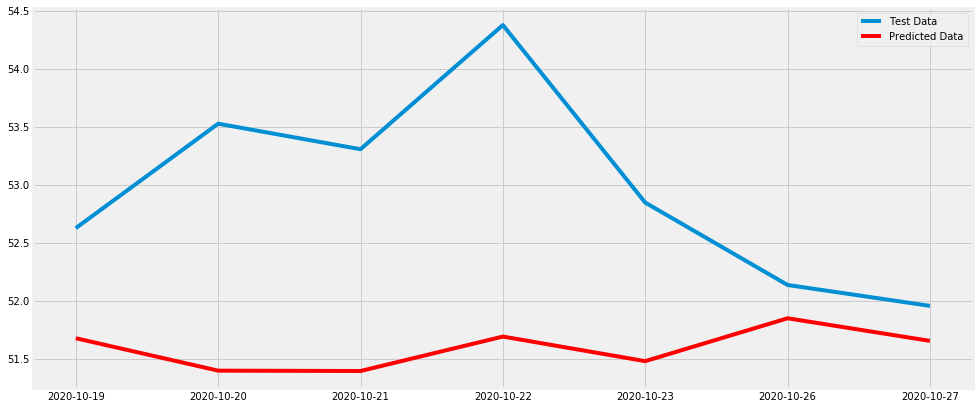

In [35]:
plt.figure(figsize=(15, 7))
plt.plot(test_data)
plt.plot(fin_pred, color='red')
plt.legend(('Test Data', 'Predicted Data'))
plt.show()

Now, we find out the series of residuals and series of square of residuals

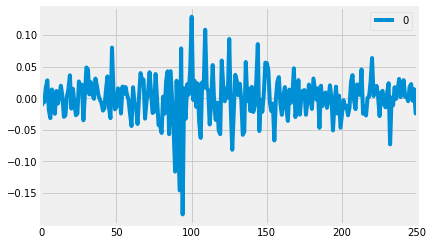

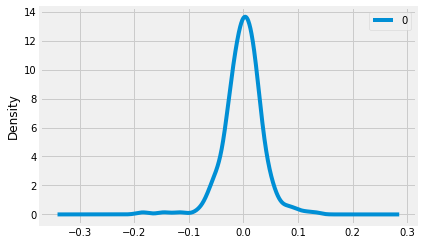

                0
count  251.000000
mean     0.000010
std      0.034576
min     -0.183982
25%     -0.017129
50%      0.001712
75%      0.018214
max      0.129005


In [36]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

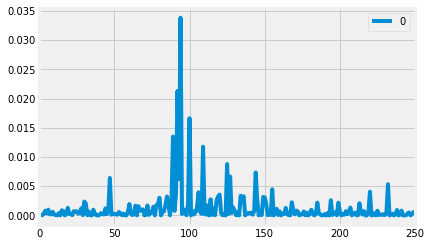

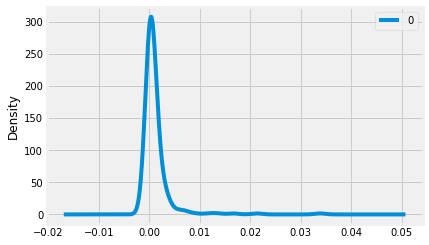

                  0
count  2.510000e+02
mean   1.190722e-03
std    3.119211e-03
min    2.209310e-07
25%    7.046024e-05
50%    3.233516e-04
75%    9.124339e-04
max    3.384951e-02


In [37]:
res_square = residuals**2
res_square.plot()
res_square.plot(kind='kde')
plt.show()
print(res_square.describe())

Apply ljungbox Test for stationarity check

In [38]:
sm.stats.acorr_ljungbox(residuals, lags= [10], boxpierce= True)

(array([14.94096187]),
 array([0.13422915]),
 array([14.39515271]),
 array([0.15571834]))

As p- value = 0.1342 > 0.05, hence Null Hypothesis is accepted.

In [39]:
sm.stats.acorr_ljungbox(res_square, lags= [10], boxpierce= True)

(array([67.03511009]),
 array([1.65092747e-10]),
 array([65.33316696]),
 array([3.49989092e-10]))

As p- value = 1.651e-10 < 0.05, hence Null Hypothesis is rejected.

Apply Garch Model

In [40]:
def ts_plot(residuals, stan_residuals, lags=50):
    residuals.plot(title='GARCH Residuals', figsize=(15, 10))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=20)
    acf.set_figheight(5)
    acf.set_figwidth(15)
    pacf.set_figheight(5)
    pacf.set_figwidth(15)
    plt.show()

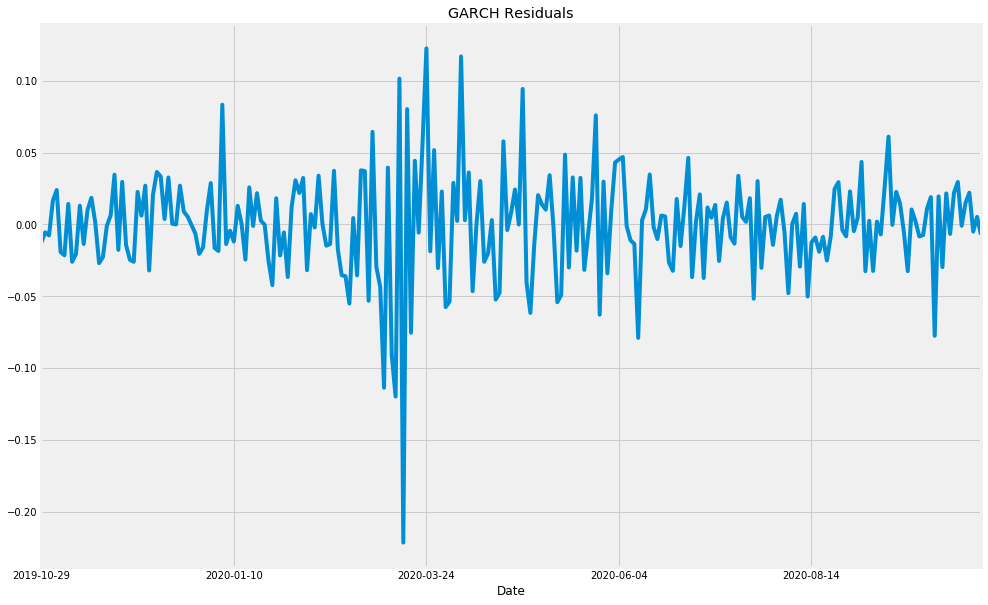

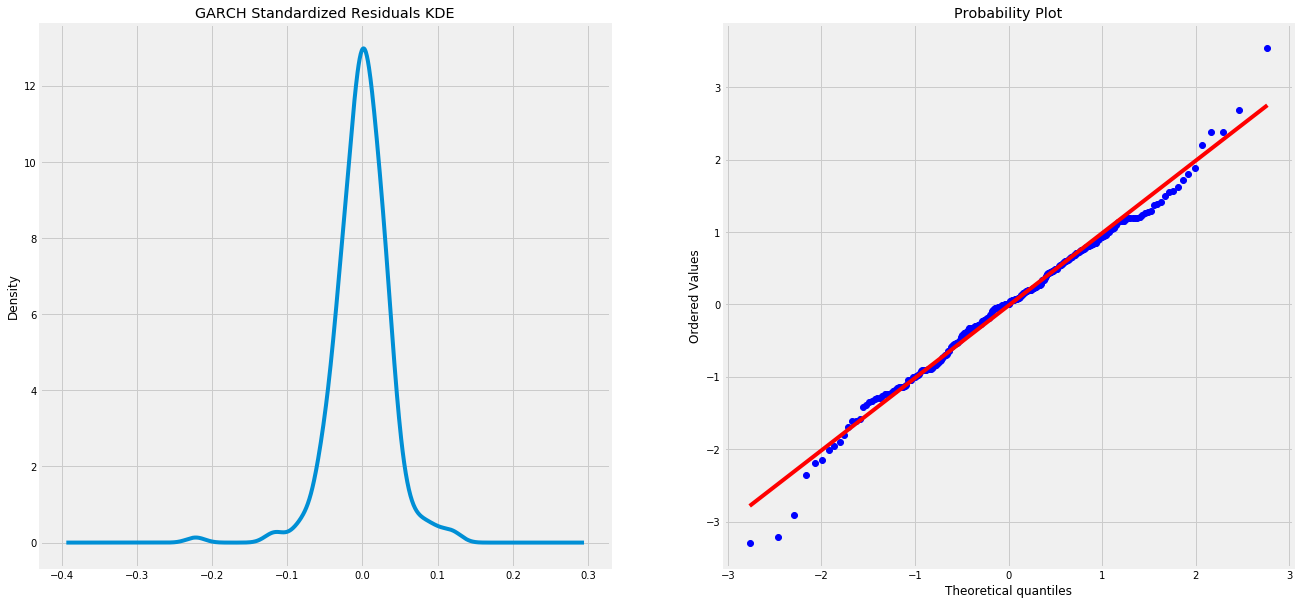

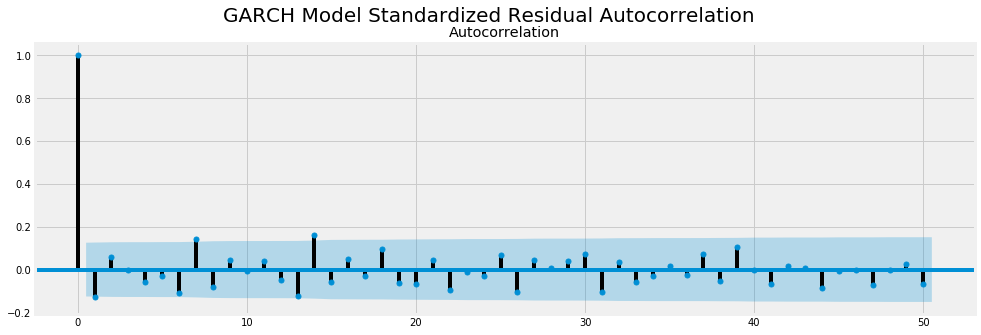

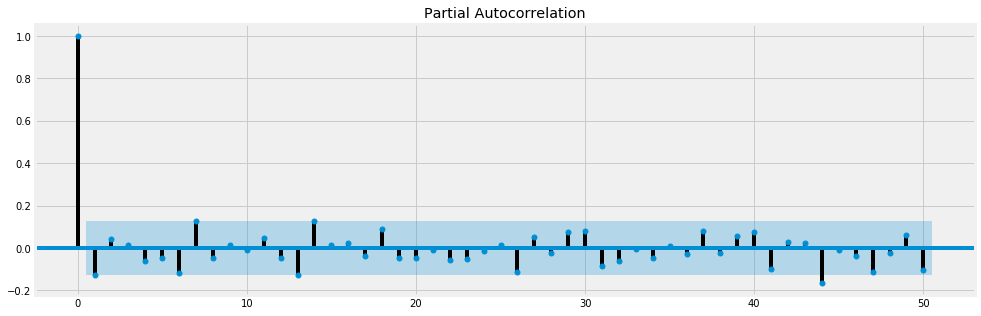

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                log_ret   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                501.911
Distribution:                  Normal   AIC:                          -995.822
Method:            Maximum Likelihood   BIC:                          -981.817
                                        No. Observations:                  245
Date:                Thu, Nov 05 2020   Df Residuals:                      241
Time:                        18:54:20   Df Model:                            4
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.5557e-04  1.764e-03      0.428      0.668 [-2.702e-03,4.213e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.3589e-05  1.904e-05      2.289  2.206e-02 [6.270e-06,8.091e-05]
alpha[1]       0.1070  4.165e-02      2.569  1.019e-02   [2.538e-02,  0.189]
beta[1]        0.8555  4.298e-02     19.906  3.587e-88     [  0.771,  0.940]
============================================================================

Covariance estimator: robust
"""

In [41]:
garch = arch_model(logtrain_data, vol='GARCH', p=1, q=1, dist='normal')
fgarch = garch.fit(disp='off') 
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)
fgarch.summary()

In [42]:
history = [x for x in logtrain_data]
test = list(logtest_data)
predictions = list()
observations = list()
for t in range(len(test)):
    model=arch_model(history, vol = 'GARCH', p=1, q=1, dist = 'normal')
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output.mean[-1:]['h.1'].values[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    observations.append(obs)

Iteration:      1,   Func. Count:      6,   Neg. LLF: -501.5544480039165
Iteration:      2,   Func. Count:     18,   Neg. LLF: -501.5921775690058
Iteration:      3,   Func. Count:     29,   Neg. LLF: -501.6359682233933
Iteration:      4,   Func. Count:     37,   Neg. LLF: -501.73675371137824
Iteration:      5,   Func. Count:     45,   Neg. LLF: -501.7823701136146
Iteration:      6,   Func. Count:     52,   Neg. LLF: -501.8284772682497
Iteration:      7,   Func. Count:     59,   Neg. LLF: -501.89696363397377
Iteration:      8,   Func. Count:     65,   Neg. LLF: -501.9093171372389
Iteration:      9,   Func. Count:     71,   Neg. LLF: -501.9111047318624
Iteration:     10,   Func. Count:     77,   Neg. LLF: -501.9111185464429
Iteration:      1,   Func. Count:      6,   Neg. LLF: -504.0496781834995
Iteration:      2,   Func. Count:     18,   Neg. LLF: -504.0936547794046
Iteration:      3,   Func. Count:     27,   Neg. LLF: -504.09654701505707
Iteration:      4,   Func. Count:     38,   Neg.

In [43]:
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], observations[i]))
error = mean_squared_error(observations, predictions)
print('Test MSE: %.6f' % error)

predicted=0.000756, expected=0.019571
predicted=0.000863, expected=0.016956
predicted=0.000964, expected=-0.004118
predicted=0.000965, expected=0.019873
predicted=0.001085, expected=-0.028539
predicted=0.000892, expected=-0.013525
predicted=0.000823, expected=-0.003458
Test MSE: 0.000300


In [44]:
fin_pred = [train_data[-1]]
for i in range(len(test_data)):
    x = fin_pred[-1]
    y = predictions[i]
    fin_pred.append(x*math.exp(y))
fin_pred = fin_pred[1:]

In [45]:
for j in range(len(fin_pred)):
    print(fin_pred[j],":", test_data[j])
error = mean_squared_error(fin_pred, test_data)
print('Test MSE: %.3f' % error)

51.649010501659795 : 52.630001
51.69360870871484 : 53.529999
51.74344793676771 : 53.310001
51.79341422500829 : 54.380001
51.84961815306325 : 52.849998
51.895903323692636 : 52.139998999999996
51.93862964211363 : 51.959998999999996
Test MSE: 2.077


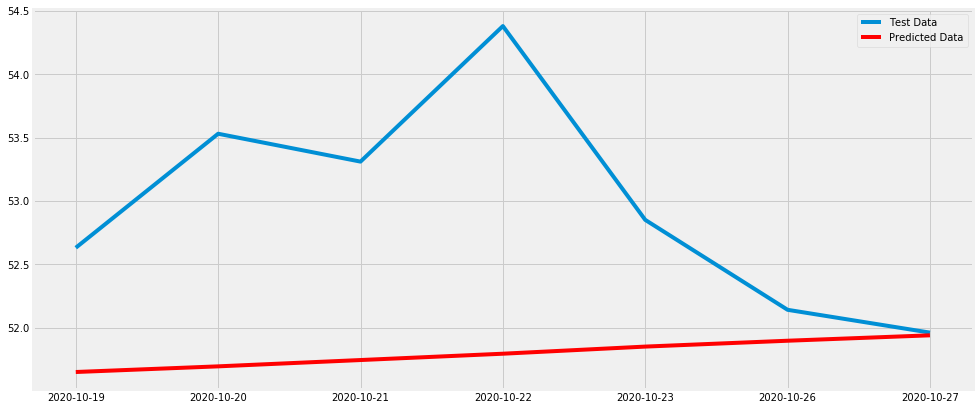

In [46]:
plt.figure(figsize=(15, 7))
plt.plot(test_data)
plt.plot(fin_pred, color='red')
plt.legend(('Test Data', 'Predicted Data'))
plt.show()